# <center><u>Flood Risk Machine Learning Tutorial</u></center>

### Introduction

<p>Urban flooding causes billions of dollars in damages annually, with severe flood events becoming more frequent and destructive as our climate changes. While extreme weather is a primary driver of flooding, its consequences depend on the interconnectedness of urban systems - referred to as the Urban Multiplex, which includes the power grid, transportation network, natural surface water and groundwater systems, sewerage and drinking water systems, intertwined with the socioeconomic and public health sectors.</p>

<p>This tutorial introduces machine learning concepts through an application in one component of the Urban Multiplex - building classification. Accurate and standardized information about buildings (e.g. classification into residential, commercial, industrial) is critical for assessing the number of people affected by flooding, the propagation of shocks throughout the economy, and for forecasting detailed socioeconomic risk from flooding. Yet, a major discrepancy exists in the way data about buildings are collected across the U.S. There is no harmonization in what data are recorded by city, county, or state governments, let alone at the national scale.</p>

<p>In this tutorial we explore multiple means of classifying a building (residential/classification/industrial/etc.) based on its features (location, square footage, proximity to other resources, etc.). Moreover, we are interested in how accurate or machine learning models can be using only free and open data. The data used in this tutorial is consistently and openly available for the continental Unites States. We use the state of North Carolina as an expemplar in this tutorial.</p>

#### Import required Python libraries

In [1]:
import time
import pickle
#import itertools
import numpy as np
import pandas as pd
#import utilities as utils
#import configuration as config
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### Setup and Configuration

In [19]:
# North Carolina data
state = 37

# input file
inFile = config.outDir + 'ML_Training_' + str(state) + '.csv'

In [20]:
# read into a Pandas dataframe
rawDf = pd.read_csv( inFile )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 
df = rawDf.copy( deep=True )

# building type distributions
print()
print( df['OrnlType'].value_counts() )
print()


Residential         976690
Commercial           64029
Industrial           16722
Assembly              7323
Education             6457
Government            4910
Agriculture           1651
Utility and Misc       362
Name: OrnlType, dtype: int64



In [4]:
976690/df['OrnlType'].value_counts()

Residential            1.000000
Commercial            15.253869
Industrial            58.407487
Assembly             133.372935
Education            151.260647
Government           198.918534
Agriculture          591.574803
Utility and Misc    2698.038674
Name: OrnlType, dtype: float64

## Pre-processing

In [4]:
df.loc[df["OrnlType"] != "Residential", "OrnlType"] = 'Other'

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])


# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

In [21]:
rawDf.loc[rawDf["OrnlType"] != "Residential", "OrnlType"] = 'Other'

rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

In [23]:
le.inverse_transform([0,1])

array(['Other', 'Residential'], dtype=object)

## KNN with unbalanced classes

In [59]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
193493,1.502876,-2.707201,-0.000232,-0.758522,-0.912652,1.396497,-0.176921,-1.178786,-0.785080,-0.766564,-0.908346,-0.791413,4,1
376480,-0.181352,1.167340,-0.134830,-0.937660,-0.273707,0.026131,0.091464,-0.758292,-0.383523,-0.202516,-0.520841,-0.321399,4,1
240184,1.122137,0.051155,-0.076402,-0.803459,-1.068631,-0.697542,-1.071538,0.033225,-1.138290,-1.189600,-1.155967,-0.976654,4,1
1051555,0.628161,1.056288,-0.144390,0.061124,-0.745051,0.324158,-0.713691,-1.277726,-0.785143,-0.625552,-0.540825,-1.002265,4,1
175429,1.440587,-2.659607,-0.195494,-0.758522,-0.912652,1.396497,0.426945,-1.178786,-0.785080,-0.766564,-0.908346,-0.791413,4,1


In [61]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

X = df.drop(['OrnlType'], axis=1).values
y = df['OrnlType'].values

ks = [3,5,7,9]
for k in ks:
    fold = 1
    accs = []
    print( "K:", k, "Fold:", fold )
    for trainIndex, testIndex in kf.split(X):
        X_train, X_test = X[trainIndex], X[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit( X_train, y_train )
        predictions = knn.predict(X_test)
        ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
        print( "  Balanced Accuracy:", ba )
        print( "  Micro F1:", np.round( f1_score(y_test, predictions, average='micro'), 4 ))
        accs.append( ba )
        fold += 1
    print( "Average Balance Accuracy:", np.round(np.mean(accs),4) )
    print()

K: 3 Fold: 1
  Balanced Accuracy: 0.8291
  Micro F1: 0.9517
  Balanced Accuracy: 0.8252
  Micro F1: 0.9505
  Balanced Accuracy: 0.828
  Micro F1: 0.951
  Balanced Accuracy: 0.8261
  Micro F1: 0.9513
  Balanced Accuracy: 0.8272
  Micro F1: 0.9514
Average Balance Accuracy: 0.8271

K: 5 Fold: 1
  Balanced Accuracy: 0.8292
  Micro F1: 0.9534
  Balanced Accuracy: 0.8271
  Micro F1: 0.9526
  Balanced Accuracy: 0.8289
  Micro F1: 0.9531
  Balanced Accuracy: 0.8252
  Micro F1: 0.9529
  Balanced Accuracy: 0.8272
  Micro F1: 0.953
Average Balance Accuracy: 0.8275

K: 7 Fold: 1
  Balanced Accuracy: 0.8295
  Micro F1: 0.9544
  Balanced Accuracy: 0.8282
  Micro F1: 0.9534
  Balanced Accuracy: 0.8285
  Micro F1: 0.9537
  Balanced Accuracy: 0.8254
  Micro F1: 0.9538
  Balanced Accuracy: 0.8255
  Micro F1: 0.9536
Average Balance Accuracy: 0.8274

K: 9 Fold: 1
  Balanced Accuracy: 0.8279
  Micro F1: 0.9544
  Balanced Accuracy: 0.8266
  Micro F1: 0.9537
  Balanced Accuracy: 0.8277
  Micro F1: 0.954
  Ba

In [62]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit( X_train, y_train )

with open('./knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

In [63]:
# read the model from file                                                                                                                                                                                                         
with open('./knn_model.pkl', 'rb') as f:
    knn = pickle.load(f)

predictions = knn.predict(X_test)
print(predictions[0:5])

[1 1 1 1 1]


In [64]:
cm = confusion_matrix( y_test, predictions, normalize='true' )

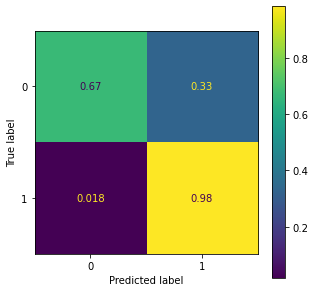

In [65]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=knn.classes_ )
disp.plot(ax=ax)

## Random Forest with unbalanced classes

In [66]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
218378,-78.738287,35.230602,124.269200,27421.0,142175.0,0.424748,8.0,50,19875,6,379,2644,4,1
470391,-81.860694,36.130880,607.280040,22034.0,13827.0,0.776536,1.0,17,1340,0,6,363,4,1
544237,-80.728102,35.141435,1026.323292,36443.0,478966.0,0.429380,78.0,38,118034,39,2607,17352,4,0
1008353,-78.813565,35.949306,593.706900,35085.0,144559.0,0.445026,70.0,0,26758,12,892,3732,4,1
816272,-78.464398,35.951898,153.408900,41189.0,462582.0,0.409578,22.5,119,105723,30,2778,17780,4,1


In [9]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8538
Micro F1: 0.9618

Balanced Accuracy: 0.8533
Micro F1: 0.9619

Balanced Accuracy: 0.8546
Micro F1: 0.962

Balanced Accuracy: 0.8543
Micro F1: 0.962

Balanced Accuracy: 0.8534
Micro F1: 0.9616

Average Balanced Accuracy: 0.8539


In [10]:
with open('./rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [11]:
# read the model from file                                                                                                                                                                                                         
with open('./rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)

predictions = rf.predict(X_test)
print( predictions[0:5] )

[1 1 1 1 1]


In [72]:
cm = confusion_matrix( y_test, predictions, normalize='true' )

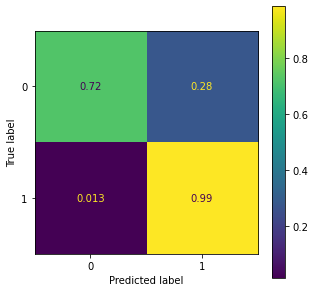

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax)

## Neural Network with unbalanced classes

In [23]:
# This is required for my GPU: GeForce RTX 2060
# Without this config, tensorflow cannot properly allocate GPU memory

# This is a GPU specific configuration and may not be needed on your GPU

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
session = tf.compat.v1.Session(config=config)

2022-11-16 11:03:37.008032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 11:03:37.117250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:03:37.311773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 11:03:37.311927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [75]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['OrnlType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

Creating test/train split...


In [76]:
print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Training Size: (862513, 12)
Testing Size: (215629, 12)


In [82]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es])

Epoch 1/150
3370/3370 [==============================] - 13s 4ms/step - loss: 0.1715 - accuracy: 0.9428
Epoch 2/150
3370/3370 [==============================] - 12s 3ms/step - loss: 0.1596 - accuracy: 0.9456
Epoch 3/150
3370/3370 [==============================] - 14s 4ms/step - loss: 0.1581 - accuracy: 0.9458
Epoch 4/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.1567 - accuracy: 0.9460
Epoch 5/150
3370/3370 [==============================] - 11s 3ms/step - loss: 0.1554 - accuracy: 0.9463
Epoch 6/150
3370/3370 [==============================] - 9s 3ms/step - loss: 0.1544 - accuracy: 0.9465
Epoch 7/150
3370/3370 [==============================] - 7s 2ms/step - loss: 0.1536 - accuracy: 0.9467
Epoch 8/150
3370/3370 [==============================] - 10s 3ms/step - loss: 0.1531 - accuracy: 0.9468
Epoch 9/150
3370/3370 [==============================] - 12s 4ms/step - loss: 0.1528 - accuracy: 0.9469
Epoch 10/150
3370/3370 [==============================] - 12s 4ms/

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                390       
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 2)                 32        
                                                                 
Total params: 887
Trainable params: 887
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 0, 'Epoch')

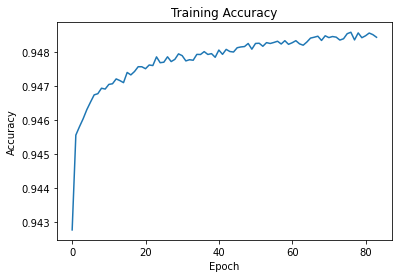

In [84]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [85]:
model.save_weights("./nn_model.h5")

In [86]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

6739/6739 [==============================] - 7s 1ms/step - loss: 0.1487 - accuracy: 0.9477
Accuracy on the test set: 0.9477


In [87]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

6739/6739 [==============================] - 7s 997us/step


215629

In [88]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Micro F1:", np.round( f1_score(yTest.values, predictions, average='micro'), 4 ))

Balanced Accuracy: 0.7918
Micro F1: 0.9477


In [89]:
cm = confusion_matrix( yTest.values, predictions, normalize='true' )

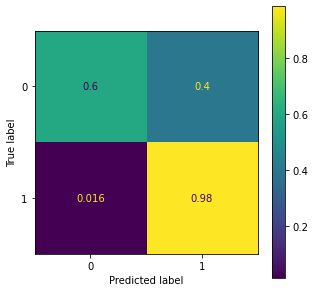

In [90]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax)

## Feature Importance

Elapsed time to compute the importances: 46.692 seconds


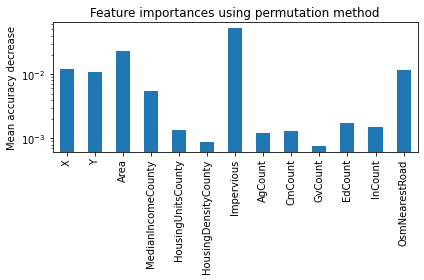

In [91]:
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

## Remove features that are not important/helpful to simplify the model

In [12]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType', 'HousingUnitsCounty', 'HousingDensityCounty', 'AgCount', 'CmCount',
                'GvCount', 'EdCount', 'InCount'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8458
Micro F1: 0.9596

Balanced Accuracy: 0.8464
Micro F1: 0.9599

Balanced Accuracy: 0.8466
Micro F1: 0.96

Balanced Accuracy: 0.8452
Micro F1: 0.9596

Balanced Accuracy: 0.847
Micro F1: 0.9598

Average Balanced Accuracy: 0.8462


In [13]:
with open('./rf_reduced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Strategies to deal with unbalanced classes

In [25]:
from imblearn.under_sampling import NearMiss

# define the undersampling method
undersample = NearMiss( version=3, n_neighbors_ver3=5 )

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

# transform the dataset
X, y = undersample.fit_resample( X, y )

In [26]:
ix = np.where( y == 1 )
print( "Residential:", len(ix[0]) )

ix = np.where( y == 0 )
print( "Other:", len(ix[0]) )

Residential: 101453
Other: 101453


In [27]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.8435
Micro F1: 0.8435

Balanced Accuracy: 0.8422
Micro F1: 0.8422

Balanced Accuracy: 0.8409
Micro F1: 0.8409

Balanced Accuracy: 0.8389
Micro F1: 0.8388

Balanced Accuracy: 0.8377
Micro F1: 0.8377

Average Balanced Accuracy: 0.8406


In [28]:
with open('./rf_balanced_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

## Threshold Moving

In [6]:
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve

# generate dataset
X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# fit a model
print("Fitting the model...")
model = RandomForestClassifier(class_weight='balanced')
model.fit(trainX, trainy)

# predict probabilities
print("Making predictions...")
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curve
print("Generating precision-recall curve...")
precision, recall, thresholds = precision_recall_curve(testy, yhat)

Fitting the model...
Making predictions...
Generating precision-recall curve...


In [8]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.550000, F-Score=0.979


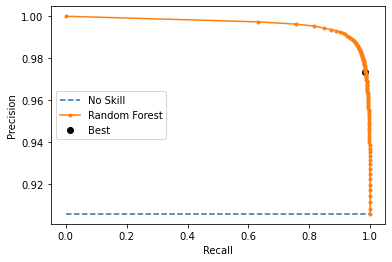

In [9]:
# plot the curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Random Forest')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

In [10]:
threshold = 0.55

predicted_proba = model.predict_proba(testX)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

ba = np.round( balanced_accuracy_score(testy, predicted), 4 )

print( "Balanced Accuracy:", ba)
print( "Micro F1:", np.round( f1_score(testy, predicted, average='micro'), 4 ))

Balanced Accuracy: 0.8625
Micro F1: 0.9615


In [11]:
with open('./rf_model_threshold_moving.pkl', 'wb') as f:
    pickle.dump(model, f)

## Multi-class classification of 'Other' buildings

In [12]:
# read into a Pandas dataframe
rawDf = pd.read_csv( inFile )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

# drop the 'Residential' rows
rawDf = rawDf[ rawDf['OrnlType'] != 'Residential' ]

# building type distributions
print()
print( rawDf['OrnlType'].value_counts() )
print()


Commercial          64029
Industrial          16722
Assembly             7323
Education            6457
Government           4910
Agriculture          1651
Utility and Misc      362
Name: OrnlType, dtype: int64



In [7]:
# building type distributions
print()
print( 64029/rawDf['OrnlType'].value_counts() )
print()


Commercial            1.000000
Industrial            3.829028
Assembly              8.743548
Education             9.916215
Government           13.040530
Agriculture          38.781950
Utility and Misc    176.875691
Name: OrnlType, dtype: float64



## Preprocess

In [13]:
rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

In [9]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
396141,-83.804861,35.326250,631.087392,21315.0,5212.0,0.649066,79.000000,0,258,0,0,125,2,2
398707,-80.424583,35.238472,642.403200,28219.0,27685.0,0.442932,77.666667,53,3568,3,41,1137,5,2
411882,-77.392176,36.093472,965.513124,20777.0,24735.0,0.508720,23.000000,40,2843,0,31,335,4,1
469797,-81.874861,36.160509,416.269263,22034.0,13827.0,0.776536,85.000000,17,1340,0,6,363,4,3
372410,-79.777546,36.075880,377.242300,30173.0,232277.0,0.429110,45.666667,21,45798,18,915,8411,4,3


## Random Forest Multiclass Classifier

In [10]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.4306
Micro F1: 0.732

Balanced Accuracy: 0.4413
Micro F1: 0.732

Balanced Accuracy: 0.4374
Micro F1: 0.7345

Balanced Accuracy: 0.4324
Micro F1: 0.7285

Balanced Accuracy: 0.4527
Micro F1: 0.732

Average Balanced Accuracy: 0.4389


In [11]:
with open('./rf_model_multi.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [12]:
predictions = rf.predict(X_test)
cm = confusion_matrix( y_test, predictions, normalize='true' )

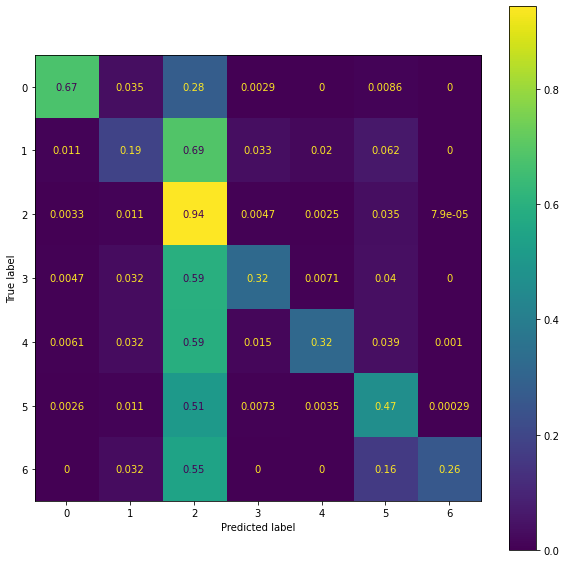

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax)

In [18]:
le.inverse_transform( np.arange(0,7,1) )

array(['Agriculture', 'Assembly', 'Commercial', 'Education', 'Government',
       'Industrial', 'Utility and Misc'], dtype=object)

Elapsed time to compute the importances: 5.254 seconds


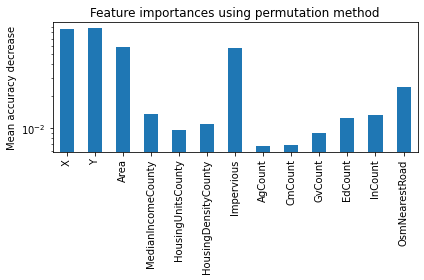

In [15]:
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

## One-vs-One Classification

In [19]:
from sklearn.multiclass import OneVsOneClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

# define ovo strategy
ovo = OneVsOneClassifier(rf)

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):

    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    
    ovo.fit(X_train, y_train)
    
    # make predictions
    yhat = ovo.predict(X_test)

    ba = np.round( balanced_accuracy_score(y_test, yhat), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, yhat, average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.4174
Micro F1: 0.7314

Balanced Accuracy: 0.4202
Micro F1: 0.7297

Balanced Accuracy: 0.421
Micro F1: 0.7316

Balanced Accuracy: 0.4246
Micro F1: 0.7302

Balanced Accuracy: 0.4323
Micro F1: 0.7302

Average Balanced Accuracy: 0.4231


## One-vs-Rest Classification

In [15]:
from sklearn.multiclass import OneVsRestClassifier

# define model
rf = RandomForestClassifier(class_weight='balanced')
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

# define ovr strategy
ovr = OneVsRestClassifier(rf)

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):

    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    
    ovr.fit(X_train, y_train)
    
    # make predictions
    yhat = ovr.predict(X_test)

    ba = np.round( balanced_accuracy_score(y_test, yhat), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, yhat, average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.452
Micro F1: 0.7298

Balanced Accuracy: 0.4445
Micro F1: 0.7352

Balanced Accuracy: 0.4483
Micro F1: 0.7376

Balanced Accuracy: 0.4201
Micro F1: 0.7311

Balanced Accuracy: 0.4483
Micro F1: 0.7322

Average Balanced Accuracy: 0.4426


## KNN for multiclass classification

In [20]:
df = rawDf.copy( deep=True )

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])


# preprossing - drop rows with NaN values
df = df.dropna()
    
# preprocessing - change output labels from text ('Agriculture') to integers
nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] )
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
        
# preprocessing - change output labels of nearest road type from text to integers
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) 
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

In [21]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
396141,-2.999478,-0.384327,-0.208826,-1.877928,-1.114897,2.777497,0.537005,-1.188718,-0.974440,-1.086440,-0.927055,-1.083775,2,2
398707,-0.602368,-0.550883,-0.205789,-0.649437,-0.988190,-0.063427,0.481579,0.249099,-0.900131,-0.864828,-0.889530,-0.933204,5,2
411882,1.548051,1.071458,-0.119061,-1.973660,-1.004822,0.843267,-1.790868,-0.103573,-0.916408,-1.086440,-0.898682,-1.052530,4,1
469797,-1.630826,1.198659,-0.266487,-1.749990,-1.066324,4.534276,0.786420,-0.727531,-0.950150,-1.086440,-0.921564,-1.048364,4,3
372410,-0.143524,1.038077,-0.276963,-0.301745,0.165337,-0.253911,-0.848634,-0.619017,0.047923,0.243231,-0.089597,0.149058,4,3


In [22]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )

X = df.drop(['OrnlType'], axis=1).values
y = df['OrnlType'].values

ks = [3,5,7,9]
for k in ks:
    fold = 1
    accs = []
    print( "K:", k, "Fold:", fold )
    for trainIndex, testIndex in kf.split(X):
        X_train, X_test = X[trainIndex], X[testIndex]
        y_train, y_test = y[trainIndex], y[testIndex]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit( X_train, y_train )
        predictions = knn.predict(X_test)
        ba = np.round( balanced_accuracy_score(y_test, predictions), 4 )
        print( "  Balanced Accuracy:", ba )
        print( "  Micro F1:", np.round( f1_score(y_test, predictions, average='micro'), 4 ))
        accs.append( ba )
        fold += 1
    print( "Average Balance Accuracy:", np.round(np.mean(accs),4) )
    print()

K: 3 Fold: 1
  Balanced Accuracy: 0.339
  Micro F1: 0.6171
  Balanced Accuracy: 0.3487
  Micro F1: 0.6152
  Balanced Accuracy: 0.3482
  Micro F1: 0.616
  Balanced Accuracy: 0.3451
  Micro F1: 0.6205
  Balanced Accuracy: 0.3523
  Micro F1: 0.6135
Average Balance Accuracy: 0.3467

K: 5 Fold: 1
  Balanced Accuracy: 0.3286
  Micro F1: 0.6407
  Balanced Accuracy: 0.3292
  Micro F1: 0.6346
  Balanced Accuracy: 0.3293
  Micro F1: 0.636
  Balanced Accuracy: 0.3214
  Micro F1: 0.639
  Balanced Accuracy: 0.3323
  Micro F1: 0.6364
Average Balance Accuracy: 0.3282

K: 7 Fold: 1
  Balanced Accuracy: 0.3072
  Micro F1: 0.6469
  Balanced Accuracy: 0.3195
  Micro F1: 0.6437
  Balanced Accuracy: 0.3219
  Micro F1: 0.6447
  Balanced Accuracy: 0.3178
  Micro F1: 0.6448
  Balanced Accuracy: 0.3293
  Micro F1: 0.6453
Average Balance Accuracy: 0.3191

K: 9 Fold: 1
  Balanced Accuracy: 0.3012
  Micro F1: 0.6524
  Balanced Accuracy: 0.3065
  Micro F1: 0.6483
  Balanced Accuracy: 0.3107
  Micro F1: 0.6477
  Ba

## Neural Network for multiclass classification

In [24]:
# columns: StateFips, CountyFips, StateCountyFips,
#          X, Y, Area, MedianIncomeCounty, HousingUnitsCounty,
#          HousingDensityCounty, Impervious, AgCount, CmCount,
#          GvCount, EdCount, InCount, OsmNearestRoad, OrnlType

# test/train split
print("Creating test/train split...")
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['OrnlType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-2]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-2]
yTrain = train.iloc[:, nCols-1]

print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

Creating test/train split...
Training Size: (81162, 12)
Testing Size: (20291, 12)


In [26]:
# convert output from scalar to vector format, i.e. building type=2 to [0,0,1,0,0,0,0,0,0,0,0]
y = to_categorical(yTrain)

# define the keras model
model = Sequential()
model.add(Dense(30, input_shape=(xTrain.shape[1],), activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# stop training if we see 7 epochs over which accuracy doesn't improve
es = EarlyStopping(monitor='accuracy', patience=7)

# fit the model
h = model.fit(xTrain, y, epochs=150, batch_size=256, callbacks=[es])

Epoch 1/150
318/318 [==============================] - 3s 3ms/step - loss: 1.2257 - accuracy: 0.6015
Epoch 2/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0818 - accuracy: 0.6345
Epoch 3/150
318/318 [==============================] - 1s 5ms/step - loss: 1.0664 - accuracy: 0.6363
Epoch 4/150
318/318 [==============================] - 2s 5ms/step - loss: 1.0578 - accuracy: 0.6375
Epoch 5/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0513 - accuracy: 0.6386
Epoch 6/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0461 - accuracy: 0.6387
Epoch 7/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0429 - accuracy: 0.6391
Epoch 8/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0400 - accuracy: 0.6394
Epoch 9/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0375 - accuracy: 0.6399
Epoch 10/150
318/318 [==============================] - 1s 4ms/step - loss: 1.0360 - accura

Text(0.5, 0, 'Epoch')

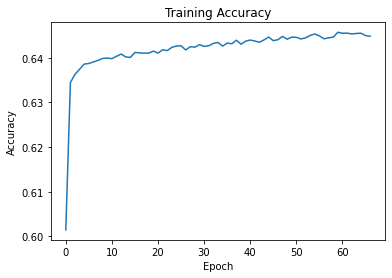

In [27]:
plt.plot( h.history['accuracy'] )
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [28]:
y = to_categorical(yTest)
loss, acc = model.evaluate( xTest, y )
print("Accuracy on the test set:", np.round(acc,4))

635/635 [==============================] - 1s 1ms/step - loss: 1.0181 - accuracy: 0.6454
Accuracy on the test set: 0.6454


In [29]:
ps = model.predict(xTest)
predictions = []
for p in ps:
    predictions.append( np.argmax( p ) )
len(predictions)

635/635 [==============================] - 1s 1ms/step


20291

In [30]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, predictions), 4 ))
print( "Micro F1:", np.round( f1_score(yTest.values, predictions, average='micro'), 4 ))

Balanced Accuracy: 0.2174
Micro F1: 0.6454


## Resort to Commercial vs 'Other'

In [25]:
# read into a Pandas dataframe
rawDf = pd.read_csv( inFile )

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 

# drop the 'Residential' rows
rawDf = rawDf[ rawDf['OrnlType'] != 'Residential' ]

# keep commercial
rawDf.loc[ (rawDf["OrnlType"] != "Commercial"), "OrnlType"] = 'Other'

rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

# building type distributions
print()
print( rawDf['OrnlType'].value_counts() )
print()


Commercial    64029
Other         37424
Name: OrnlType, dtype: int64



In [26]:
rawDf = rawDf.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

rawDf = rawDf.dropna()

nCols = rawDf.shape[1]
le = preprocessing.LabelEncoder()
le.fit( rawDf.iloc[:, nCols-1] ) # ornl type
rawDf.iloc[:, nCols-1] = le.transform( rawDf.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( rawDf.iloc[:, nCols-2] ) # nearest road type
rawDf.iloc[:, nCols-2] = le2.transform( rawDf.iloc[:, nCols-2] )

In [29]:
le.inverse_transform( [0,1] )

array(['Commercial', 'Other'], dtype=object)

In [37]:
rawDf.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,OrnlType
978018,-78.746157,35.754306,9974.600074,41189.0,462582.0,0.409578,84.428571,119,105723,30,2778,17780,5,0
7112,-80.614768,35.482176,175.442100,34297.0,87410.0,0.387106,54.000000,19,14422,6,289,3751,2,0
762593,-78.575417,35.728102,870.116017,41189.0,462582.0,0.409578,61.250000,119,105723,30,2778,17780,7,1
860728,-78.403750,35.854028,401.941200,41189.0,462582.0,0.409578,4.000000,119,105723,30,2778,17780,7,0
448110,-80.896065,35.602731,1072.344742,31174.0,79372.0,0.425147,69.000000,54,15474,9,281,3990,4,0


In [38]:
kf = KFold( n_splits=5, shuffle=True, random_state=42 )
rf = RandomForestClassifier(class_weight='balanced')

X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

accs = []
for trainIndex, testIndex in kf.split(X):
    X_train, X_test = X[trainIndex], X[testIndex]
    y_train, y_test = y[trainIndex], y[testIndex]
    rf.fit( X_train, y_train )
    ba = np.round( balanced_accuracy_score(y_test, rf.predict(X_test)), 4 )
    accs.append( ba )
    print( "Balanced Accuracy:", ba)
    print( "Micro F1:", np.round( f1_score(y_test, rf.predict(X_test), average='micro'), 4 ))
    print()
print( "Average Balanced Accuracy:", np.round(np.mean(accs),4) )

Balanced Accuracy: 0.7381
Micro F1: 0.7738

Balanced Accuracy: 0.7332
Micro F1: 0.7695

Balanced Accuracy: 0.7363
Micro F1: 0.7706

Balanced Accuracy: 0.7284
Micro F1: 0.7646

Balanced Accuracy: 0.7359
Micro F1: 0.7714

Average Balanced Accuracy: 0.7344


In [39]:
predictions = rf.predict(X_test)
cm = confusion_matrix( y_test, predictions, normalize='true' )

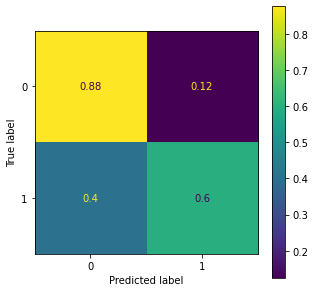

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(ax=ax)

In [42]:
with open('./rf_model_commercial.pkl', 'wb') as f:
    pickle.dump(rf, f)

Elapsed time to compute the importances: 4.393 seconds


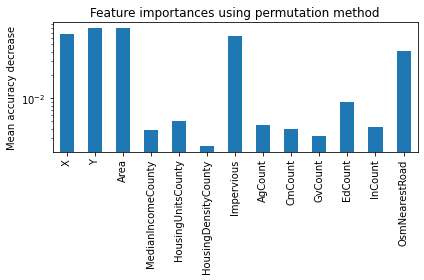

In [43]:
start_time = time.time()
result = permutation_importance(
    rf, X_test, y_test, n_repeats=1, random_state=42, n_jobs=1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=df.columns[:-1])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation method")
ax.set_ylabel("Mean accuracy decrease")
ax.set_yscale('log')
fig.tight_layout()
plt.show()

## Threshold moving

In [20]:
# generate dataset
X = rawDf.drop(['OrnlType'], axis=1).values
y = rawDf['OrnlType'].values

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# fit a model
print("Fitting the model...")
model = RandomForestClassifier(class_weight='balanced')
model.fit(trainX, trainy)

# predict probabilities
print("Making predictions...")
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate precision-recall curve
print("Generating precision-recall curve...")
precision, recall, thresholds = precision_recall_curve(testy, yhat)

Fitting the model...
Making predictions...
Generating precision-recall curve...


In [21]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.400000, F-Score=0.698


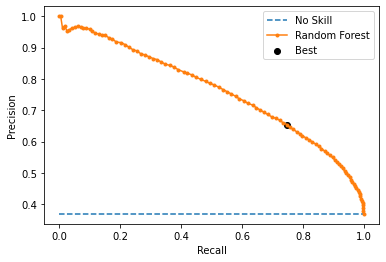

In [22]:
# plot the curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Random Forest')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()

# show the plot
pyplot.show()

In [23]:
threshold = 0.40

predicted_proba = model.predict_proba(testX)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

ba = np.round( balanced_accuracy_score(testy, predicted), 4 )

print( "Balanced Accuracy:", ba)
print( "Micro F1:", np.round( f1_score(testy, predicted, average='micro'), 4 ))

Balanced Accuracy: 0.7584
Micro F1: 0.7612


In [24]:
with open('./rf_model_threshold_moving_commercial_v_other.pkl', 'wb') as f:
    pickle.dump(model, f)

## Final workflow 
* Predict with Residential vs. Other model
* If 'Other', predict with Commercial vs. Other model

In [48]:
# our saved models
residentialOther = './rf_model_threshold_moving.pkl'
commercialOther = './rf_model_threshold_moving_commercial_v_other.pkl'
    
# read the models from file                                                                                                                                                                                                         
with open(residentialOther, 'rb') as f:
    residentialModel = pickle.load(f)
with open(commercialOther, 'rb') as f:
    commercialModel = pickle.load(f)

In [49]:
# unknown buildings in North Carolina
unknown = pd.read_csv( config.outDir + '/unknownBuildings.csv' )

unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
0,37,99,37099,-83.260602,35.484954,20.716411,22429.0,26649.0,0.618177,2.0,22,2860,3,51,804,tertiary,0.0
1,37,99,37099,-83.155694,35.493472,68.605588,22429.0,26649.0,0.618177,6.0,22,2860,3,51,804,secondary,0.0
2,37,99,37099,-83.155694,35.493287,246.025647,22429.0,26649.0,0.618177,8.0,22,2860,3,51,804,secondary,0.0
3,37,99,37099,-83.154768,35.491620,142.232825,22429.0,26649.0,0.618177,0.0,22,2860,3,51,804,secondary,0.0
4,37,99,37099,-83.158009,35.486898,170.658810,22429.0,26649.0,0.618177,0.5,22,2860,3,51,804,residential,0.0


In [50]:
# shuffle the dataframe (technically, we randomly resample the entire df)
unknown = unknown.sample(frac=1) 

unknown = unknown.dropna()

nCols = unknown.shape[1]    
le = preprocessing.LabelEncoder()
le.fit( unknown.iloc[:, nCols-2] ) # nearest road type
unknown.iloc[:, nCols-2] = le.transform( unknown.iloc[:, nCols-2] )

In [51]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr
41735,37,179,37179,-80.490787,35.073935,6.770024,35468.0,83788.0,0.351656,1.0,44,13966,6,311,5324,4,0.0
185806,37,183,37183,-78.637176,35.584213,147.571200,41189.0,462582.0,0.409578,1.0,119,105723,30,2778,17780,7,0.0
116804,37,119,37119,-80.722268,35.176157,4.726280,36443.0,478966.0,0.429380,21.0,38,118034,39,2607,17352,4,0.0
24508,37,179,37179,-80.692824,34.950417,547.491714,35468.0,83788.0,0.351656,21.0,44,13966,6,311,5324,4,0.0
18779,37,179,37179,-80.430324,35.155231,127.916451,35468.0,83788.0,0.351656,4.0,44,13966,6,311,5324,4,0.0


In [52]:
print( unknown.shape[0], 'unknown buildings in North Carolina')

219054 unknown buildings in North Carolina


## Predict all unknown buildings in North Carolina

In [53]:
# residential prediction threshold
residentialThreshold = 0.55

# commercial prediction threshold
commercialThreshold = 0.40

# generate dataset
X = unknown.drop(['StateFips','CountyFips','StateCountyFips','FEMA_100yr'], axis=1).values

# place to put the predictions
n = unknown.shape[0]
predictions = np.empty( n, dtype=object )

# make residential vs. other prediction
# Residential = 1, Other = 0
predicted_proba = residentialModel.predict_proba(X)
rPrediction = (predicted_proba [:,1] >= residentialThreshold).astype('int')
    
# make commercial vs. other predictions
# Commercial = 0, Other = 1
predicted_proba = commercialModel.predict_proba(X)
cPrediction = (predicted_proba [:,1] >= commercialThreshold).astype('int')
        
# update prediction array
ix = np.where( rPrediction == 1 )
predictions[ ix[0] ] = 'residential'
ix = np.where( rPrediction == 0 )
for i in ix[0]:
    if ( cPrediction[i] == 0 ):
        predictions[i] = 'commercial'
    else:
        predictions[i] = 'other'
            
unknown['predictions'] = predictions

print()
print( unknown['predictions'].value_counts() )
print()


residential    210203
commercial       5238
other            3613
Name: predictions, dtype: int64



In [54]:
unknown.head()

,StateFips,CountyFips,StateCountyFips,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,FEMA_100yr,predictions
41735,37,179,37179,-80.490787,35.073935,6.770024,35468.0,83788.0,0.351656,1.0,44,13966,6,311,5324,4,0.0,residential
185806,37,183,37183,-78.637176,35.584213,147.571200,41189.0,462582.0,0.409578,1.0,119,105723,30,2778,17780,7,0.0,residential
116804,37,119,37119,-80.722268,35.176157,4.726280,36443.0,478966.0,0.429380,21.0,38,118034,39,2607,17352,4,0.0,residential
24508,37,179,37179,-80.692824,34.950417,547.491714,35468.0,83788.0,0.351656,21.0,44,13966,6,311,5324,4,0.0,residential
18779,37,179,37179,-80.430324,35.155231,127.916451,35468.0,83788.0,0.351656,4.0,44,13966,6,311,5324,4,0.0,residential


## Connect predictions with socio-economic data and FEMA 100-year flood predictions

In [56]:
flood = unknown[ unknown['FEMA_100yr'] == 1 ]

In [58]:
residential = flood[ flood['predictions'] == 'residential' ]
commercial = flood[ flood['predictions'] == 'commercial' ]
other = flood[ flood['predictions'] == 'other' ]

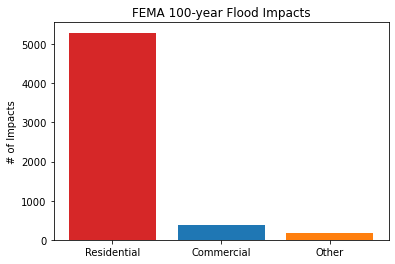

In [62]:
fig, ax = plt.subplots()

types = ['Residential', 'Commercial', 'Other']
counts = [ residential.shape[0], commercial.shape[0], other.shape[0]]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

ax.bar(types, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('# of Impacts')
ax.set_title('FEMA 100-year Flood Impacts')

plt.show()

Text(0.5, 0, 'Median Individual Income in County')

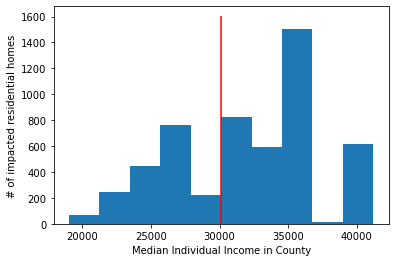

In [71]:
m = 30106 # median individal income in NC in 2020

plt.hist( residential['MedianIncomeCounty'] )
plt.plot( np.zeros(1600)+m, np.arange(0,1600,1), c='red' )
plt.ylabel('# of impacted residential homes')
plt.xlabel('Median Individual Income in County')

In [81]:
ix = np.where( residential['MedianIncomeCounty'] < m )
p = (len(ix[0])/residential['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% residential buildings impacted are in counties below median income')

32.81 % residential buildings impacted are in counties below median income


Text(0.5, 0, 'Median Individual Income in County')

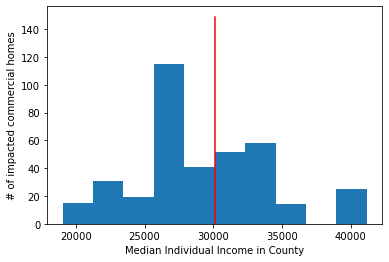

In [74]:
m = 30106 # median individal income in NC in 2020

plt.hist( commercial['MedianIncomeCounty'] )
plt.plot( np.zeros(150)+m, np.arange(0,150,1), c='red' )
plt.ylabel('# of impacted commercial homes')
plt.xlabel('Median Individual Income in County')

In [82]:
ix = np.where( commercial['MedianIncomeCounty'] < m )
p = (len(ix[0])/commercial['MedianIncomeCounty'].shape[0])*100.
print( np.round(p,2), '% commercial buildings impacted are in counties below median income')

59.73 % commercial buildings impacted are in counties below median income
